In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
# Extras
from matplotlib.patches import FancyArrowPatch

In [2]:
# Get cpu, gpu or mps device for training.
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first CUDA device
else:
    device = torch.device("cpu")  # Fallback to CPU

print(f"Using {device} device")
torch.cuda.get_device_name(0)

Using cuda:0 device


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

# Data Generating Process, NOT USED


In [3]:
def generate_vector_batches(count: int, dim: int, n: int, device: torch.device, seed: int = 42):
    """
    Generates count batches of a tensor with shape (2, n, dim) on the specified device.
    
    Parameters:
    count (int): Number of batches to generate.
    dim (int): Dimension of each vector.
    n (int): Number of vectors in each batch.
    device (torch.device): The device on which to create the tensors.
    seed (int, optional): Random seed for reproducibility.
    
    Returns:
    List[torch.Tensor]: List of batches, each batch is a tensor with shape (2, n, dim).
    """

    if(seed != None):
        torch.manual_seed(seed)
    
    batches = []
    
    for _ in range(count):
        # Generate the first list of n vectors in R^d on the specified device
        vectors1 = torch.rand((n, dim), device=device)
        
        # Generate the second list of n vectors in R^d on the specified device
        vectors2 = torch.rand((n, dim), device=device)
        
        # Stack the two lists along a new dimension to create a tensor of shape (2, n, dim)
        batch = torch.stack((vectors1, vectors2), dim=0)
        
        # Add the tensor to the batches list
        batches.append(batch)
    
    return batches


# Generate batches with a specific seed
seed = 42
batches = generate_vector_batches(count = 3, dim = 5, n = 4, device = device, seed = seed)
for i, batch in enumerate(batches):
    print(f"Batch {i+1}:")
    print(batch)
    print(batch.shape)
    print()


Batch 1:
tensor([[[0.6130, 0.0101, 0.3984, 0.0403, 0.1563],
         [0.4825, 0.7362, 0.4060, 0.5189, 0.2867],
         [0.2416, 0.9228, 0.8299, 0.0342, 0.3879],
         [0.0824, 0.7742, 0.2792, 0.5138, 0.2068]],

        [[0.9877, 0.1289, 0.5621, 0.5221, 0.7445],
         [0.5955, 0.9647, 0.8979, 0.7730, 0.6681],
         [0.5462, 0.5071, 0.5882, 0.2555, 0.8963],
         [0.1866, 0.7235, 0.1781, 0.9880, 0.6289]]], device='cuda:0')
torch.Size([2, 4, 5])

Batch 2:
tensor([[[0.8259, 0.2128, 0.7292, 0.3209, 0.7550],
         [0.2132, 0.9278, 0.1442, 0.3472, 0.9975],
         [0.5531, 0.2491, 0.9302, 0.2792, 0.8427],
         [0.5213, 0.1384, 0.6954, 0.5918, 0.8705]],

        [[0.7296, 0.1194, 0.0511, 0.2384, 0.2015],
         [0.6364, 0.7799, 0.5795, 0.5838, 0.0749],
         [0.9054, 0.2269, 0.5483, 0.3980, 0.4130],
         [0.7970, 0.0470, 0.9436, 0.1394, 0.6422]]], device='cuda:0')
torch.Size([2, 4, 5])

Batch 3:
tensor([[[0.3264, 0.9967, 0.0706, 0.2893, 0.5037],
         [0.1414, 

* Duplicate batches checker (Needed because of seed)

In [4]:
def check_for_duplicates(batches):
    """
    Checks for duplicate batches in the list.
    
    Parameters:
    batches (List[torch.Tensor]): List of batches to check for duplicates.
    
    Returns:
    List[int]: List of indices of duplicate batches.
    """
    seen = set()
    duplicates = []
    
    for i, batch in enumerate(batches):
        # Convert the tensor to a hashable type (e.g., a tuple)
        batch_tuple = tuple(batch.cpu().numpy().ravel())
        if batch_tuple in seen:
            duplicates.append(i)
        else:
            seen.add(batch_tuple)
    
    return duplicates

seed = 42
check_for_duplicates(generate_vector_batches(count = 50000, dim = 2, n = 4, device = device, seed = seed))

[]

* No Duplicate generation detected

# Projection functions and testing

* ## Primal Projection Methods

Original Code

In [5]:
# def softmax(matrix):
#     # Subtract the max for numerical stability
#     exp_matrix = np.exp(matrix - np.max(matrix, axis=0, keepdims=True))
#     # Apply softmax
#     softmax_matrix = exp_matrix / np.sum(exp_matrix, axis=0, keepdims=True)
#     return softmax_matrix
# # --------------------------------------------
# def normalize_row(row):
#     row_sum = np.sum(row)
#     if row_sum > 1:
#         return row / row_sum
#     return row
# # --------------------------------------------
# def normalize_matrix_rows(matrix):
#     # Apply normalization to each row
#     normalized_mat = np.array([normalize_row(row) for row in matrix])
#     return normalized_mat
# # --------------------------------------------
# def get_row_sums(matrix):
#     return np.sum(matrix, axis=1)
# def get_col_sums(matrix):
#     return np.sum(matrix, axis=0)
# # --------------------------------------------
# def primal_projection(matrix):
#     ret_mat = normalize_matrix_rows(softmax(matrix)).copy()
#     r = get_row_sums(ret_mat)
#     c = get_col_sums(ret_mat)
#     r_tild = np.ones(len(ret_mat)) - r
#     c_tild = np.ones(len(ret_mat)) - c
#     # Actual computation
#     ret_mat = ret_mat + (1/np.sum(c_tild))*np.outer(r_tild,c_tild)
#     return ret_mat

In [6]:
import torch

def softmax(matrix,axis = None,T=1):
    exp_matrix = torch.exp(matrix/T - torch.max(matrix, dim=axis, keepdim=True).values)
    softmax_matrix = exp_matrix / torch.sum(exp_matrix, dim=axis, keepdim=True)
    return softmax_matrix


def normalize_axis(to_normalize, axis=None):
    axis_sum = torch.sum(to_normalize, dim=axis, keepdim=True)
    
    # Normalize only if the sum is greater than 1
    if torch.any(axis_sum > 1):
        return to_normalize / axis_sum
    return to_normalize


def normalize_matrix_axis(matrix,axis = None):
    slices = [normalize_axis(to_normalize=matrix.select(axis, i), axis=None) for i in range(matrix.size(axis))]
    return torch.stack(slices, dim=axis)


def get_axis_sums(matrix,axis = None):
    return torch.sum(matrix, dim=axis)


def primal_projection(matrix,axis = None):
    ret_mat = normalize_matrix_axis(matrix = softmax(matrix = matrix,axis = axis),axis = axis).clone()
    r = get_axis_sums(ret_mat,axis = 1)
    c = get_axis_sums(ret_mat,axis = 0)
    r_tild = torch.ones(len(ret_mat), device=matrix.device) - r
    c_tild = torch.ones(len(ret_mat[0]), device=matrix.device) - c
    ret_mat = ret_mat + (1 / torch.sum(c_tild)) * torch.outer(r_tild, c_tild)
    return ret_mat

# Example usage
matrix = torch.tensor(data = [[1,3,5],[4,3,2],[5,3,35]])  # Example random matrix
projected_matrix = primal_projection(matrix = matrix, axis = 0) # Row example
print("Original matrix:")
print(matrix)
print("\nProjected matrix:")
print(projected_matrix)


Original matrix:
tensor([[ 1,  3,  5],
        [ 4,  3,  2],
        [ 5,  3, 35]])

Projected matrix:
tensor([[0.2426, 0.4393, 0.3180],
        [0.4063, 0.3984, 0.1953],
        [0.3511, 0.1622, 0.4867]])


* ## Dual Projection Methods
* - Non symmetric version

In [7]:
def dual_projection(f, g, cost):
    """
    Perform dual projection to obtain f_ret and g_ret.
    
    Parameters:
    f (torch.Tensor): A 1D tensor with the f values.
    g (torch.Tensor): A 1D tensor with the g values.
    cost (torch.Tensor): A 2D tensor with cost values where cost[i][k] is the cost value.

    Returns:
    torch.Tensor: f_ret tensor.
    torch.Tensor: g_ret tensor.
    """
    # Ensure input tensors are on the same device
    device = f.device
    
    # Compute g_ret (which is simply g)
    g_ret = g.clone()
    
    # Compute the cost matrix subtraction
    cost_minus_g = cost - g.unsqueeze(1)  # Broadcasting to subtract g from each column in cost
    
    # Compute min_over_k(cost[i][k] - g[k])
    min_cost_minus_g = torch.min(cost_minus_g, dim=1).values
    
    # Compute f_ret
    f_ret = torch.minimum(f, min_cost_minus_g)
    
    return f_ret, g_ret

# Example usage
f = torch.tensor([10.0, 20.0, 30.0], dtype=torch.float32)
g = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32)
cost = torch.tensor([[4.0, 5.0, 6.0],
                     [7.0, 8.0, 9.0],
                     [10.0, 11.0, 12.0]], dtype=torch.float32)

f_ret, g_ret = dual_projection(f, g, cost)
print("f_ret:", f_ret)
print("g_ret:", g_ret)


f_ret: tensor([3., 5., 7.])
g_ret: tensor([1., 2., 3.])


# Actual Data Generating Process With Noise

In [45]:
import torch
import numpy as np

def generate_batches_noise(count: int, dim: int, n: int, device: torch.device,
                           seed: int = 42, 
                           coardinate_max: float = 20,
                           noise_scaler = 0.4):
    """
    Generates `count` batches of a tensor with shape (2, n, dim) on the specified device.
    The second group of vectors is the first group randomly permutated with added noise.
    
    Parameters:
    count (int): Number of batches to generate.
    dim (int): Dimension of each vector.
    n (int): Number of vectors in each batch.
    device (torch.device): The device on which to create the tensors.
    seed (int, optional): Random seed for reproducibility.
    coardinate_max (float, optional): Max absolute value of any coordinate.

    noise_scaler: has to be less than 0.5 for validity
    Returns:
    List[torch.Tensor]: List of batches, each batch is a tensor with shape (2, n, dim).
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    batches = []
    perm_list = []
    
    for _ in range(count):
        # Generate the first list of n vectors in R^d on the specified device
        vectors1 = 2 * coardinate_max * torch.rand((n, dim), device=device) - coardinate_max
        
        # Permute the indices of the first set of vectors
        permuted_indices = np.random.permutation(n)
        vectors2 = vectors1[permuted_indices]
        
        # Add scaled noise to the permuted vectors in a valid manner
        # Calculate pairwise squared differences
        dists = torch.cdist(vectors2, vectors2, p=2)
        
        # Mask out the diagonal (distances between identical rows, which are zero)
        dists.fill_diagonal_(float('inf'))
        
        # Find the minimum distance for each row
        min_distances, _ = torch.min(dists, dim=1)
        noise_valid_scaler =  torch.sqrt(torch.min(min_distances))
        
        noise = torch.randn_like(vectors2,device=device)
        noise = noise /noise.norm(dim=1, keepdim=True)
        vectors2 += noise* noise_valid_scaler *noise_scaler
        
        # Stack the two lists along a new dimension to create a tensor of shape (2, n, dim)
        batch = torch.stack((vectors1, vectors2), dim=0)
        
        # Add the tensor to the batches list
        batches.append(batch)
        perm_list.append(permuted_indices)
    
    return batches,perm_list


In [46]:
# Generate batches with a specific seed
seed = 420
count = 1
dim = 2
n = 4
device = device
coardinate_max= 50
batches,perm_list = generate_batches_noise(count = count,
                                           dim = dim,
                                           n = n,
                                           device = device,
                                           seed = seed,
                                           coardinate_max= coardinate_max)
for i, batch in enumerate(batches):
    print(f"Batch {i+1}:")
    print(batch)
    print(f"Permutation:{perm_list[i]}")


Batch 1:
tensor([[[ 30.5354, -30.0960],
         [ 47.5853, -39.7183],
         [-15.2540, -34.4567],
         [ 38.5615,  18.7572]],

        [[ 40.3305,  18.8123],
         [-13.5445, -34.9149],
         [ 30.7131, -31.8569],
         [ 48.7214, -41.0754]]])
Permutation:[3 2 0 1]


In [47]:
batches[0][0][perm_list[0]]

tensor([[ 38.5615,  18.7572],
        [-15.2540, -34.4567],
        [ 30.5354, -30.0960],
        [ 47.5853, -39.7183]])

In [48]:
(batches[0][0][perm_list[0]] - batches[0][1]).abs().mean()

tensor(1.0530)

## Visualization

In [49]:
def plot_batches_with_arrows(batches, perm_list, colors, labels):
    """
    Plots batches of vectors and connects corresponding vectors with arrows.

    Parameters:
    - batches: List of tensors, where each tensor is of shape (2, n, dim)
    - perm_list: List of permutations used to align vectors in the second set
    - colors: List of colors for the scatter plots
    - labels: List of labels for the legend
    """
    plt.figure(figsize=(8, 6))

    for i, batch in enumerate(batches):
        # Extract vectors from batch
        vectors1 = batch[0].numpy()
        vectors2 = batch[1].numpy()

        # Plot the first set of vectors
        plt.scatter(vectors1[:, 0], vectors1[:, 1], color=colors[0], label=f'{labels[i]} - Set 1', marker='o')

        # Plot the second set of vectors permutated
        plt.scatter(vectors2[:, 0], vectors2[:, 1], color=colors[1], label=f'{labels[i]} - Set 2', marker='x')

        # Draw green arrows between corresponding vectors in vectors1 and vectors2
        for j in range(len(vectors1)):
            start_point = (vectors1[perm_list[i][j], 0], vectors1[perm_list[i][j], 1])
            end_point = (vectors2[j, 0], vectors2[j, 1])
            
            # Create an arrow with FancyArrowPatch
            arrow = FancyArrowPatch(start_point, end_point,
                                    mutation_scale=10,
                                    arrowstyle='->',
                                    color='green',
                                    linestyle=':',
                                    linewidth=2,
                                    alpha=0.7)
            plt.gca().add_patch(arrow)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Scatter Plot of Batches with Connections')
    plt.legend()
    plt.grid(True)
    plt.show()


### Very simple test and visualization (One batch)

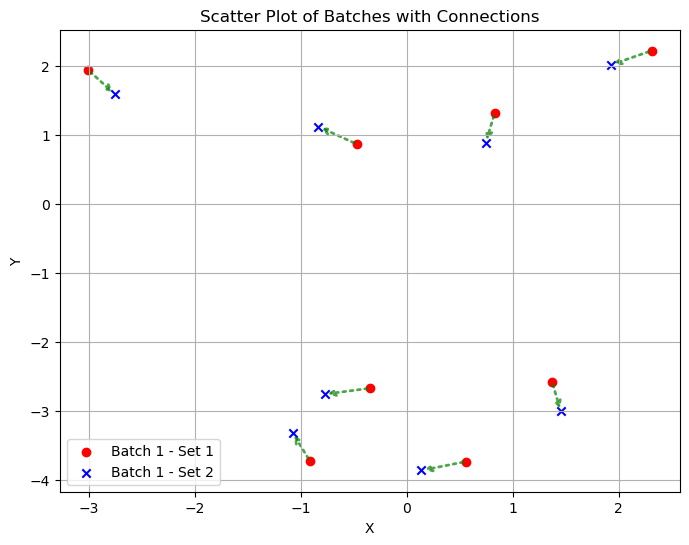

In [50]:
# Set device to CPU for plotting purposes
device = torch.device('cpu')

seed = 12
count = 1
dim = 2
n = 8
coardinate_max = 5
batches, perm_list = generate_batches_noise(count=count,
                                            dim=dim,
                                            n=n, 
                                            device=device,
                                            seed=seed,
                                            coardinate_max=coardinate_max)


colors = ['red', 'blue']
labels = ['Batch 1', 'Batch 2 permutated']
plot_batches_with_arrows(batches= batches, perm_list= perm_list, colors= colors, labels= labels)

In [51]:
batches,perm_list

([tensor([[[-0.3431, -2.6723],
           [-0.4728,  0.8711],
           [-0.9136, -3.7283],
           [ 1.3728, -2.5794],
           [ 2.3119,  2.2244],
           [-3.0076,  1.9483],
           [ 0.8300,  1.3183],
           [ 0.5589, -3.7375]],
  
          [[ 1.9251,  2.0184],
           [ 0.7473,  0.8880],
           [-0.7726, -2.7594],
           [-1.0754, -3.3210],
           [-0.8321,  1.1220],
           [-2.7536,  1.5912],
           [ 0.1398, -3.8657],
           [ 1.4546, -3.0099]]])],
 [array([4, 6, 0, 2, 1, 5, 7, 3])])

In [52]:
print(batches[0][0][perm_list])
print("-------------------------")
print(batches[0][1])

tensor([[ 2.3119,  2.2244],
        [ 0.8300,  1.3183],
        [-0.3431, -2.6723],
        [-0.9136, -3.7283],
        [-0.4728,  0.8711],
        [-3.0076,  1.9483],
        [ 0.5589, -3.7375],
        [ 1.3728, -2.5794]])
-------------------------
tensor([[ 1.9251,  2.0184],
        [ 0.7473,  0.8880],
        [-0.7726, -2.7594],
        [-1.0754, -3.3210],
        [-0.8321,  1.1220],
        [-2.7536,  1.5912],
        [ 0.1398, -3.8657],
        [ 1.4546, -3.0099]])


In [53]:
(batches[0][0][perm_list[0]] - batches[0][1]).abs().mean()

tensor(0.2795)

In [54]:
noises = (batches[0][0][perm_list[0]] - batches[0][1])
noises

tensor([[ 0.3868,  0.2060],
        [ 0.0828,  0.4303],
        [ 0.4295,  0.0870],
        [ 0.1619, -0.4072],
        [ 0.3593, -0.2509],
        [-0.2540,  0.3570],
        [ 0.4190,  0.1282],
        [-0.0817,  0.4305]])

### Minor stress test and visualization (One batch still)

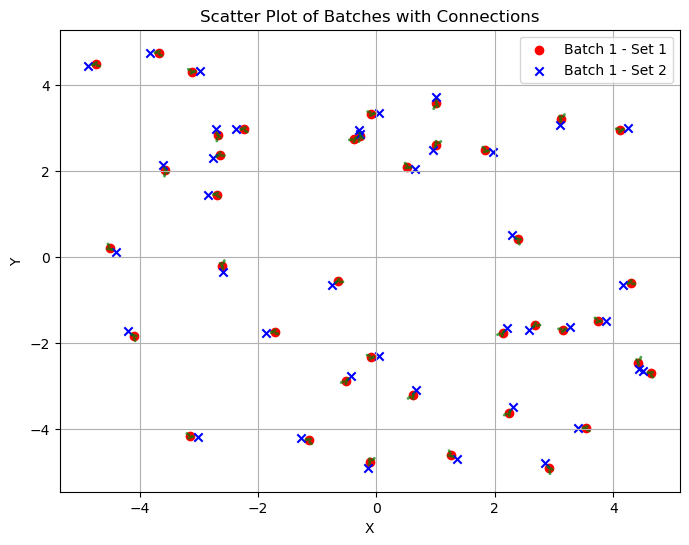

In [71]:
# Set device to CPU for plotting purposes
device = torch.device('cpu')

seed = 20
count = 1
dim = 2
n = 40
coardinate_max = 5
batches, perm_list = generate_batches_noise(count=count,
                                            dim=dim,
                                            n=n, 
                                            device=device,
                                            seed=seed,
                                            coardinate_max=coardinate_max)


colors = ['red', 'blue']
labels = ['Batch 1', 'Batch 2 permutated']
plot_batches_with_arrows(batches= batches, perm_list= perm_list, colors= colors, labels= labels)